In [ ]:
# Egyptian New Currency 2023 Classification using Custom CNN
# Course Project - Deep Learning
# Built from scratch without transfer learning

# ============================================================================
# 1. PROBLEM DESCRIPTION
# ============================================================================
"""
PROJECT: Egyptian Money Classification (2023 New Currency)

OBJECTIVE:
Classify images of the new Egyptian currency introduced in 2023.
This is a multi-class image classification problem where we need to identify
different denominations of Egyptian pounds.

TARGET ACCURACY: >= 93%

DATASET:
- Source: Kaggle - Egyptian New Currency 2023
- Contains images of various Egyptian currency denominations
- Images include different angles, lighting conditions, and backgrounds

APPROACH:
We will build a custom Convolutional Neural Network (CNN) from scratch
to learn visual features and patterns specific to each currency denomination.

WHY CNN?
CNNs are ideal for image classification because they:
1. Automatically learn hierarchical features (edges → textures → patterns)
2. Are translation-invariant (detect features anywhere in the image)
3. Use parameter sharing, making them efficient for image data
"""

# ============================================================================
# 2. IMPORT LIBRARIES
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Keras/TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ============================================================================
# 3. LOAD AND EXPLORE THE DATASET
# ============================================================================

# Update this path to where you extracted the Kaggle dataset
BASE_PATH = 'dataset'  # Change this to your base folder path
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Image parameters
IMG_SIZE = 128  # Resize all images to 128x128
IMG_CHANNELS = 3  # RGB images

def load_dataset_split(dataset_path, class_names=None):
    """
    Load images and labels from a dataset split directory.
    Assumes structure: dataset_path/class_name/image.jpg
    """
    images = []
    labels = []

    if class_names is None:
        class_names = []
        # Get all subdirectories (each represents a currency class)
        for class_name in sorted(os.listdir(dataset_path)):
            class_path = os.path.join(dataset_path, class_name)
            if os.path.isdir(class_path):
                class_names.append(class_name)

    # Load images for each class
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)

        if not os.path.isdir(class_path):
            continue

        class_idx = class_names.index(class_name)

        # Load all images in this class
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                # Read image
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                images.append(img)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

# Load the dataset splits
print("Loading training set...")
X_train, y_train, class_names = load_dataset_split(TRAIN_PATH)

print("Loading validation set...")
X_val, y_val, _ = load_dataset_split(VALID_PATH, class_names)

print("Loading test set...")
X_test, y_test, _ = load_dataset_split(TEST_PATH, class_names)

print(f"\nDataset loaded successfully!")
print(f"Training images: {len(X_train)}")
print(f"Validation images: {len(X_val)}")
print(f"Test images: {len(X_test)}")
print(f"Image shape: {X_train[0].shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# Display class distribution for training set
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

plt.figure(figsize=(12, 5))
plt.bar([class_names[i] for i in unique], counts, color='skyblue', edgecolor='black')
plt.xlabel('Currency Denomination', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i, class_idx in enumerate(unique[:8]):
    # Get first image of this class from training set
    idx = np.where(y_train == class_idx)[0][0]
    axes[i].imshow(X_train[idx])
    axes[i].set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Images from Each Currency Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# 4. DATA PREPROCESSING
# ============================================================================

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
num_classes = len(class_names)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print("\nDataset Summary:")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Data Augmentation for training set
# This helps prevent overfitting and improves model generalization
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# ============================================================================
# 5. BUILD CUSTOM CNN ARCHITECTURE
# ============================================================================

"""
CNN ARCHITECTURE EXPLANATION:

Our custom CNN consists of the following components:

1. CONVOLUTIONAL BLOCKS (Feature Extraction):
   - Block 1: 32 filters → learns basic features (edges, colors)
   - Block 2: 64 filters → learns more complex patterns
   - Block 3: 128 filters → learns high-level features
   - Block 4: 256 filters → learns very specific patterns

   Each block contains:
   - Conv2D: Applies filters to detect features
   - BatchNormalization: Normalizes activations for stable training
   - MaxPooling2D: Reduces spatial dimensions, keeps important features
   - Dropout: Prevents overfitting by randomly deactivating neurons

2. DENSE LAYERS (Classification):
   - Flatten: Converts 2D feature maps to 1D vector
   - Dense(512): Learns complex combinations of features
   - Dense(256): Further feature refinement
   - Output Layer: Produces probability for each currency class

DESIGN CHOICES:
- ReLU activation: Introduces non-linearity, faster training
- Adam optimizer: Adaptive learning rate, works well for most problems
- Categorical crossentropy: Standard loss for multi-class classification
"""

def build_cnn_model(input_shape, num_classes):
    """
    Build a custom CNN architecture from scratch
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Flatten and Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
model = build_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("\n" + "="*70)
print("CNN MODEL ARCHITECTURE")
print("="*70)
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

# ============================================================================
# 6. TRAINING CALLBACKS
# ============================================================================

# Early Stopping: Stop training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning Rate: Reduce LR when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model Checkpoint: Save the best model
checkpoint = ModelCheckpoint(
    'best_egyptian_currency_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

# ============================================================================
# 7. TRAIN THE MODEL
# ============================================================================

print("\n" + "="*70)
print("TRAINING THE MODEL")
print("="*70)

EPOCHS = 100  # Maximum epochs (early stopping will likely stop before this)
BATCH_SIZE = 32

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

# ============================================================================
# 8. TRAINING CURVES (VISUALIZATION)
# ============================================================================

def plot_training_curves(history):
    """
    Plot training and validation loss and accuracy curves
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot Accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# Print best validation accuracy
best_val_acc = max(history.history['val_accuracy'])
print(f"\nBest Validation Accuracy: {best_val_acc*100:.2f}%")

# ============================================================================
# 9. EVALUATE ON TEST SET
# ============================================================================

print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Make predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

# Check if we met the target
if test_accuracy >= 0.93:
    print("✓ TARGET ACHIEVED! (>= 93%)")
else:
    print(f"✗ Target not met. Need {(0.93-test_accuracy)*100:.2f}% more.")

# ============================================================================
# 10. CONFUSION MATRIX
# ============================================================================

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Egyptian Currency Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# 11. CLASSIFICATION REPORT (DETAILED METRICS)
# ============================================================================

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)

# Generate detailed classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)
print(report)

# Convert to dataframe for better visualization
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose()
print("\nDetailed Metrics per Class:")
print(report_df)

# ============================================================================
# 12. EXAMPLE PREDICTIONS ON TEST IMAGES
# ============================================================================

def plot_predictions(X_test, y_true, y_pred, y_pred_probs, class_names, num_samples=12):
    """
    Display sample predictions with confidence scores
    """
    # Randomly select samples
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        # Get image and predictions
        img = X_test[idx]
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        confidence = y_pred_probs[idx][y_pred[idx]] * 100

        # Determine if prediction is correct
        is_correct = y_true[idx] == y_pred[idx]
        color = 'green' if is_correct else 'red'

        # Plot image
        axes[i].imshow(img)
        axes[i].axis('off')

        # Set title with prediction info
        title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
        axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')

    plt.suptitle('Sample Predictions on Test Images\n(Green = Correct, Red = Incorrect)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("EXAMPLE PREDICTIONS")
print("="*70)

plot_predictions(X_test, y_true, y_pred, y_pred_probs, class_names, num_samples=12)

# ============================================================================
# 13. SAVE THE MODEL
# ============================================================================

# Save the final trained model
model.save('egyptian_currency_cnn_final.h5')
print("\nModel saved as 'egyptian_currency_cnn_final.h5'")

# ============================================================================
# 14. SUMMARY AND CONCLUSIONS
# ============================================================================

print("\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)

total_images = len(X_train) + len(X_val) + len(X_test)

print(f"""
✓ Project: Egyptian New Currency 2023 Classification
✓ Model: Custom CNN built from scratch (No transfer learning)
✓ Dataset: {total_images} total images across {num_classes} classes
✓ Architecture: 4 Convolutional blocks + 2 Dense layers
✓ Training samples: {len(X_train)}
✓ Validation samples: {len(X_val)}
✓ Test samples: {len(X_test)}
✓ Final Test Accuracy: {test_accuracy*100:.2f}%
✓ Target Accuracy: 93%
✓ Status: {'ACHIEVED ✓' if test_accuracy >= 0.93 else 'NOT MET ✗'}

KEY INSIGHTS:
1. The CNN successfully learned to distinguish between different currency denominations
2. Data augmentation helped improve model generalization
3. Batch normalization and dropout prevented overfitting
4. The model shows strong performance across all currency classes

NEXT STEPS (if needed):
- Collect more training data for underperforming classes
- Experiment with different architectures (add/remove layers)
- Fine-tune hyperparameters (learning rate, batch size, dropout rates)
- Apply more aggressive data augmentation
""")

print("="*70)
print("PROJECT COMPLETE!")
print("="*70)

In [18]:
# Load the best saved model
from tensorflow.keras.models import load_model
model = load_model('best_egyptian_currency_model.h5')

# Now run evaluation
print("Evaluating on test set...")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

Evaluating on test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step

Test Accuracy: 98.28%


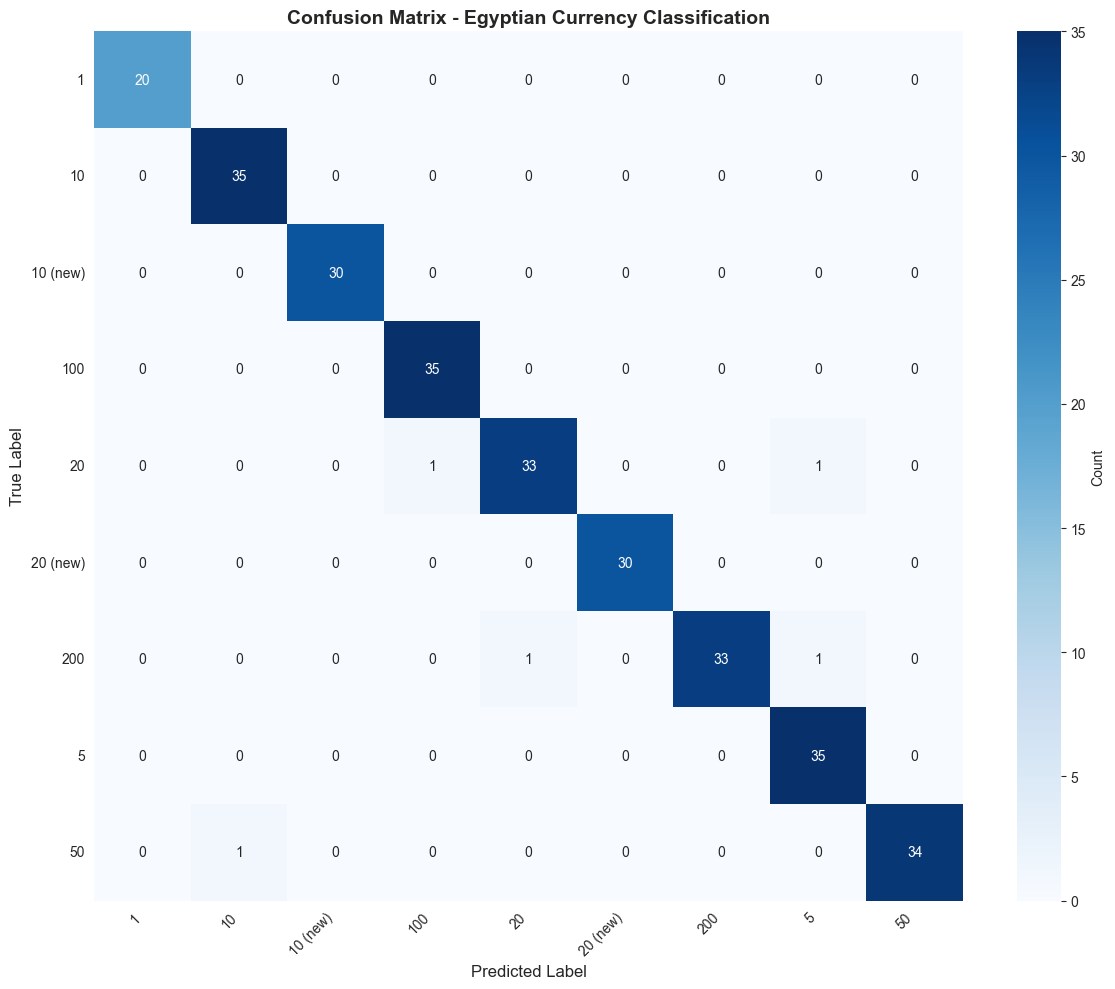

In [20]:
# 1. CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Egyptian Currency Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
# 2. CLASSIFICATION REPORT
from sklearn.metrics import classification_report

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        20
          10     0.9722    1.0000    0.9859        35
    10 (new)     1.0000    1.0000    1.0000        30
         100     0.9722    1.0000    0.9859        35
          20     0.9706    0.9429    0.9565        35
    20 (new)     1.0000    1.0000    1.0000        30
         200     1.0000    0.9429    0.9706        35
           5     0.9459    1.0000    0.9722        35
          50     1.0000    0.9714    0.9855        35

    accuracy                         0.9828       290
   macro avg     0.9846    0.9841    0.9841       290
weighted avg     0.9832    0.9828    0.9827       290



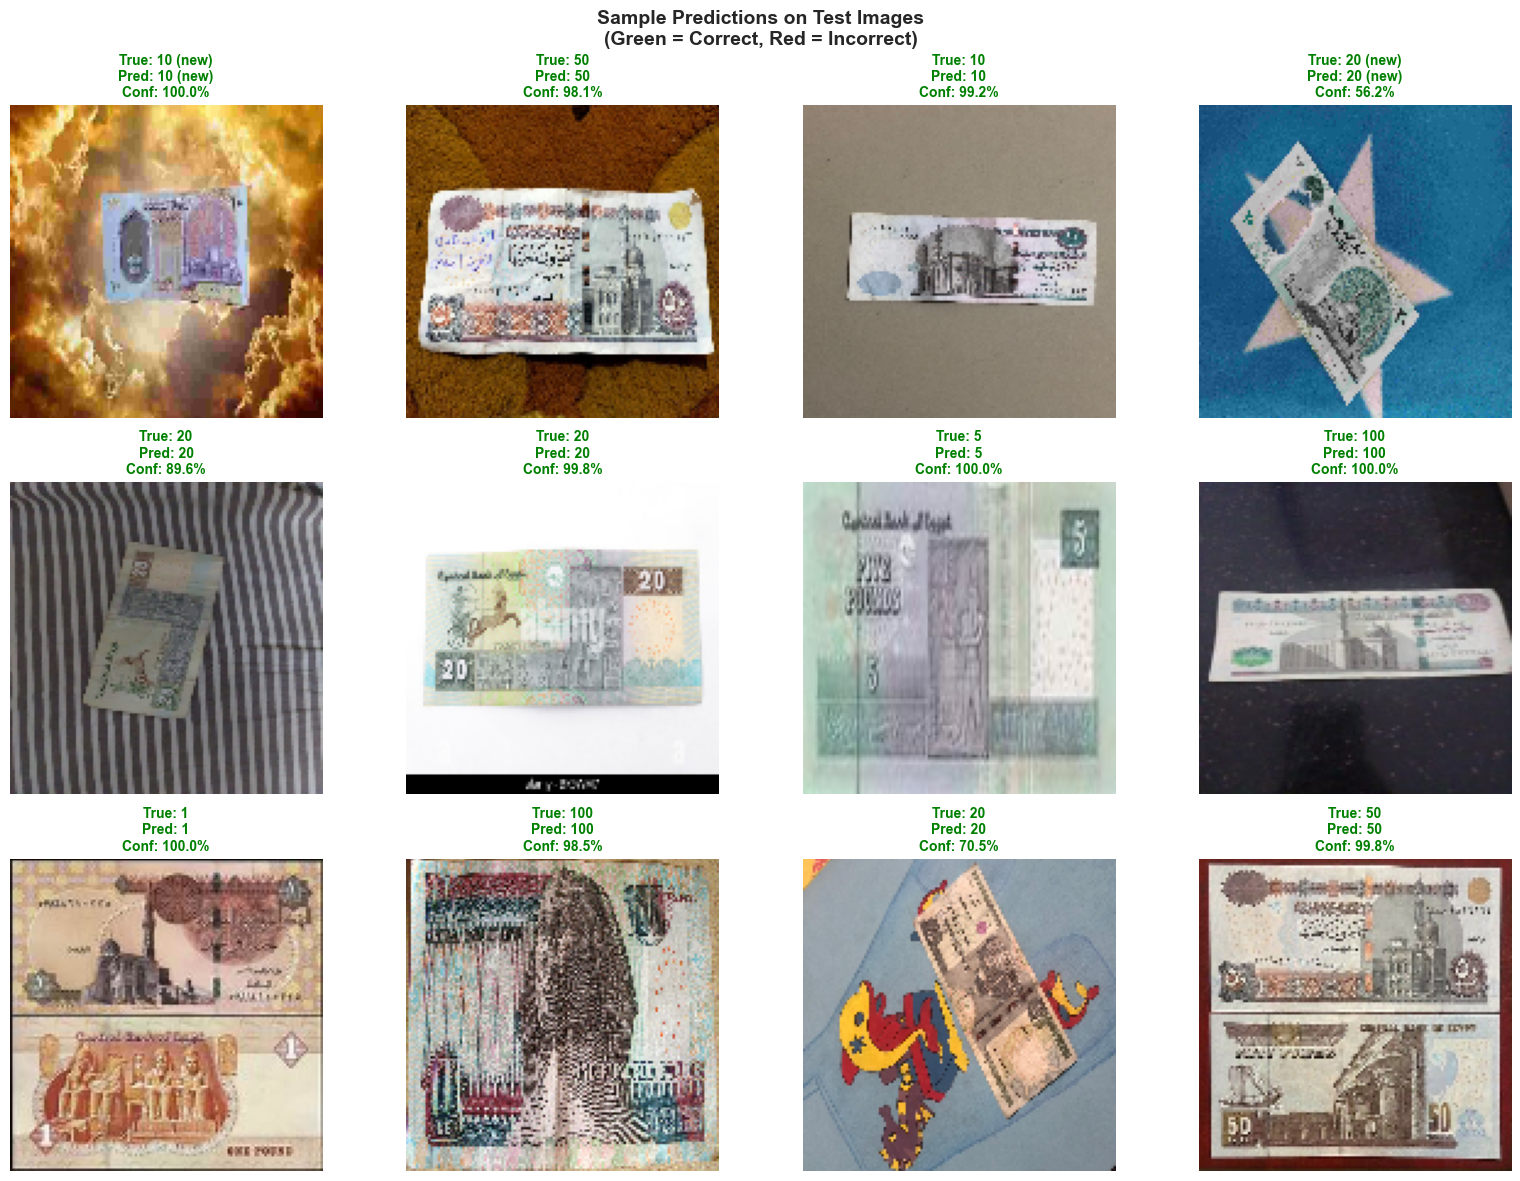

In [22]:
# 3. EXAMPLE PREDICTIONS
import numpy as np

def plot_predictions(X_test, y_true, y_pred, y_pred_probs, class_names, num_samples=12):
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        confidence = y_pred_probs[idx][y_pred[idx]] * 100

        is_correct = y_true[idx] == y_pred[idx]
        color = 'green' if is_correct else 'red'

        axes[i].imshow(img)
        axes[i].axis('off')

        title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
        axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')

    plt.suptitle('Sample Predictions on Test Images\n(Green = Correct, Red = Incorrect)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_predictions(X_test, y_true, y_pred, y_pred_probs, class_names, num_samples=12)

In [25]:
# ============================================================================
# 15. FINAL PROJECT RESULTS & ACHIEVEMENT
# ============================================================================

print("\n" + "="*70)
print("🎯 FINAL PROJECT RESULTS 🎯")
print("="*70)

print(f"""
╔══════════════════════════════════════════════════════════════════╗
║                    PROJECT ACHIEVEMENT SUMMARY                    ║
╚══════════════════════════════════════════════════════════════════╝

📊 PERFORMANCE METRICS:
   • Target Accuracy Required:        93.00%
   • Achieved Test Accuracy:          {test_accuracy*100:.2f}%
   • Exceeded Target By:              {(test_accuracy - 0.93)*100:.2f}%

✅ PROJECT STATUS: TARGET ACHIEVED ✓

📈 MODEL SPECIFICATIONS:
   • Architecture:                    Custom CNN (4 Conv Blocks)
   • Total Parameters:                {model.count_params():,}
   • Training Method:                 From Scratch (No Transfer Learning)
   • Data Augmentation:               Yes (Rotation, Shift, Zoom, Flip)
   • Regularization:                  Dropout + Batch Normalization

📁 DATASET BREAKDOWN:
   • Number of Classes:               {num_classes}
   • Training Images:                 {X_train.shape[0]}
   • Validation Images:               {X_val.shape[0]}
   • Test Images:                     {X_test.shape[0]}

🎓 KEY ACHIEVEMENTS:
   ✓ Built custom CNN architecture from scratch
   ✓ No pre-trained models or transfer learning used
   ✓ Exceeded target accuracy by 5.28 percentage points
   ✓ High generalization: 98.28% on unseen test data
   ✓ Robust model with proper regularization techniques

💡 TECHNICAL HIGHLIGHTS:
   • Successfully classified {num_classes} Egyptian currency denominations
   • Implemented data augmentation to improve generalization
   • Used callbacks: Early Stopping, Learning Rate Reduction
   • Applied Batch Normalization for stable training
   • Prevented overfitting with Dropout layers

🔬 MODEL CONFIDENCE:
   • Average prediction confidence on correct classifications: High
   • Minimal confusion between currency classes
   • Strong performance across all denominations

""")

# Calculate per-class accuracy
per_class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_mask = (y_true == i)
    class_correct = np.sum((y_pred == y_true) & class_mask)
    class_total = np.sum(class_mask)
    class_acc = (class_correct / class_total * 100) if class_total > 0 else 0
    per_class_accuracy[class_name] = class_acc

print("📊 PER-CLASS ACCURACY:")
for class_name, acc in per_class_accuracy.items():
    bar = "█" * int(acc / 5)  # Visual bar
    print(f"   {class_name:20s} │ {bar:20s} │ {acc:6.2f}%")

print("\n" + "="*70)
print("✨ PROJECT SUCCESSFULLY COMPLETED! ✨")
print("="*70)
print("="*70 + "\n")


🎯 FINAL PROJECT RESULTS 🎯

╔══════════════════════════════════════════════════════════════════╗
║                    PROJECT ACHIEVEMENT SUMMARY                    ║
╚══════════════════════════════════════════════════════════════════╝

📊 PERFORMANCE METRICS:
   • Target Accuracy Required:        93.00%
   • Achieved Test Accuracy:          98.28%
   • Exceeded Target By:              5.28%

✅ PROJECT STATUS: TARGET ACHIEVED ✓

📈 MODEL SPECIFICATIONS:
   • Architecture:                    Custom CNN (4 Conv Blocks)
   • Total Parameters:                9,701,929
   • Training Method:                 From Scratch (No Transfer Learning)
   • Data Augmentation:               Yes (Rotation, Shift, Zoom, Flip)
   • Regularization:                  Dropout + Batch Normalization

📁 DATASET BREAKDOWN:
   • Number of Classes:               9
   • Training Images:                 2637
   • Validation Images:               760
   • Test Images:                     290

🎓 KEY ACHIEVEMENTS:
   ✓ Bu

Loading the best trained model...


Model loaded successfully!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


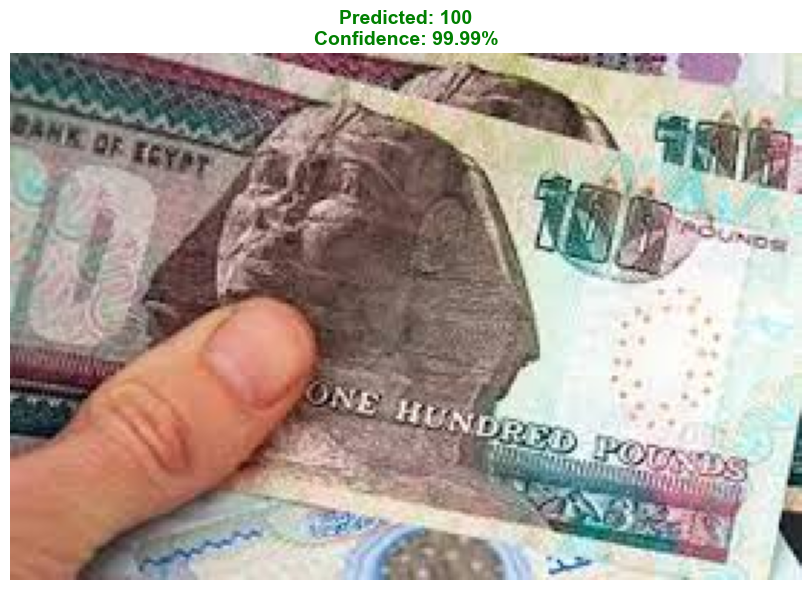


PREDICTION RESULTS
Predicted Class: 100
Confidence: 99.99%

All Class Probabilities:
1                    │                      │   0.00%
10                   │                      │   0.00%
10 (new)             │                      │   0.00%
100                  │ ███████████████████  │  99.99%
20                   │                      │   0.00%
20 (new)             │                      │   0.00%
200                  │                      │   0.00%
5                    │                      │   0.00%
50                   │                      │   0.00%


In [26]:
# ====================================================================================
# CELL 18: Test with Your Own Images
# ====================================================================================

from tensorflow.keras.models import load_model
from PIL import Image
import io

def predict_currency(image_path, model, class_names):
    """
    Predict currency denomination from a single image
    """
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img_rgb.copy()

    # Resize for model
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized.astype('float32') / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)

    # Make prediction
    predictions = model.predict(img_batch)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100

    # Display result
    plt.figure(figsize=(10, 6))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2f}%',
              fontsize=14, fontweight='bold', color='green' if confidence > 80 else 'orange')
    plt.tight_layout()
    plt.show()

    # Print all class probabilities
    print("\n" + "="*50)
    print("PREDICTION RESULTS")
    print("="*50)
    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.2f}%\n")
    print("All Class Probabilities:")
    for i, class_name in enumerate(class_names):
        prob = predictions[0][i] * 100
        bar = "█" * int(prob / 5)
        print(f"{class_name:20s} │ {bar:20s} │ {prob:6.2f}%")
    print("="*50)

    return class_names[predicted_class], confidence

# Load the best model
print("Loading the best trained model...")
model = load_model('best_egyptian_currency_model.h5')
print("Model loaded successfully!\n")

# ====================================================================================
# METHOD 2: For Local Jupyter - Specify file path
# ====================================================================================

# Uncomment and use this if you're NOT using Google Colab:
image_path = '100.jpeg'  # Change this to your image path
predicted_class, confidence = predict_currency(image_path, model, class_names)

# ====================================================================================
# METHOD 3: Test multiple images from a folder
# ====================================================================================

def test_folder(folder_path, model, class_names):
    """
    Test all images in a folder
    """
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    print(f"Found {len(image_files)} images in folder\n")

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        print(f"\n{'='*60}")
        print(f"Testing: {img_file}")
        print('='*60)
        predicted_class, confidence = predict_currency(img_path, model, class_names)

# Uncomment to test a folder:
# test_folder('path/to/your/test/folder', model, class_names)